In [21]:
import jax
import jax.numpy as jnp
import equinox
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_moons, make_blobs

In [25]:
n_cluster = 8 
radius = 8
std = 0.5
centers = np.array([np.array([jnp.cos(2 * jnp.pi * i / n_cluster)*radius, jnp.sin(2 * jnp.pi * i / n_cluster)*radius]) for i in range(n_cluster)])
blobs = make_blobs(n_samples=1000, n_features=2, centers=centers, cluster_std=std, random_state=42)

moon = make_moons(n_samples=1000, noise=0.1, random_state=43)

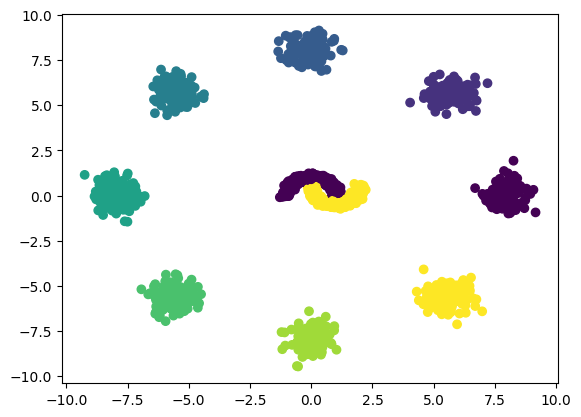

In [26]:
plt.scatter(blobs[0][:, 0], blobs[0][:, 1], c=blobs[1])
plt.scatter(moon[0][:, 0], moon[0][:, 1], c=moon[1])